In [1]:
import pandas as pd
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *

In [18]:
df = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/all_subreddits.csv')

## Preprocessing

In [19]:
import re #regex library used for substituting words

In [20]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [21]:
def post_cleaning(text):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ',text)

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    
    #remove digits
    processed_feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    return processed_feature

In [22]:
#above functions combined
def preprocessing(text):
    line = cleaning(text)
    line = post_cleaning (line)
    return line

In [23]:
df.body = df.body.apply(lambda x: preprocessing(x))

In [24]:
df.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,7951721,oakisland,1613168164,carmen legge northville farm centerville nova scotia scott doug went visit week episode think carmen northville farm time someone fellowship dig visited season could temporarily relocated due covid restrictions,0.0000
1,13261673,ukpolitics,1597987216,need expert see boris covid brexit fall guy,0.0000
2,261403,amazonfc,1634437900,made month lol worked amazon covid hit whole family got covid really go anymore lol rejoined,0.7818
3,15681814,drugs,1590316428,looks like discussing thing contact medical emergency government services country concerns seconds find whats important crew scot made awesome infographic american society addiction medicine dedicated page site contains news guidance resources around country regarding addiction treatment wake covid national institute drug abuse covid potential implications individuals substance use disorders us state may request blanket exceptions stable patients opioid treatment program receive days take home doses patient medication opioid use disorder want discuss covid leave comment official weekly fre...,0.8391
4,3153614,politics,1628274205,gt decent covid response yes killing states economy snd longest lockdowns great response california gdp saw roughly 8 drop florida saw drop california kill economy economy quite well things considering trade california roughly higher survival rate 8 economic loss seems like decent trade plus number likely go considering fact 6x many floridians currently dying covid compared californians,0.7289


In [25]:
sample = df.sample(50000)

In [27]:
for sentiment in sample['sentiment']:
    if sentiment > 0:
        sample['sentiment'].replace({sentiment : 'positive'}, inplace=True)
    if sentiment < 0:
        sample['sentiment'].replace({sentiment : 'negative'}, inplace=True)
    else:
        sample['sentiment'].replace({sentiment : 'neutral'}, inplace=True)

Text(0.5, 1.0, 'Sentiment Data Distribution')

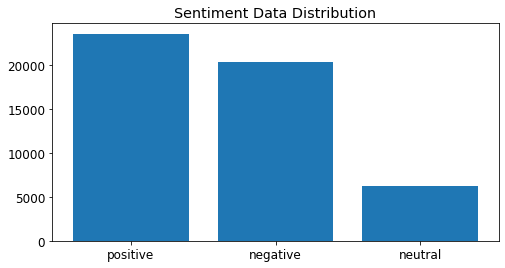

In [28]:
#Graphing
val_count = sample.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [29]:
from sklearn.model_selection import train_test_split

In [87]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(sample, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 40000
Test Data size 10000


## Vectorizing

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [88]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [89]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (40000, 14000)
x_test Shape: (10000, 14000)


In [90]:
from sklearn.preprocessing import LabelEncoder

In [91]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (40000, 1)
y_test shape: (10000, 1)


## Model

In [52]:
lb=LabelEncoder()
sample['sentiment'] = lb.fit_transform(sample['sentiment'])

In [47]:
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [68]:
model = Sequential()
model.add(Embedding(500, 120, input_length = x_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 471, 120)          60000     
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 471, 120)         0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 176)               209088    
                                                                 
 dense_3 (Dense)             (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(sample['body'].values)
X = tokenizer.texts_to_sequences(sample['body'].values)
X = pad_sequences(X)

In [74]:
y=pd.get_dummies(sample['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [99]:
X_train = tf.sparse.from_dense(X_train)
y_train = tf.sparse.from_dense(y_train)
X_train = tf.sparse.reorder(X_train)
y_train = tf.sparse.reorder(y_train)

ValueError: Attempt to convert a value (<tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7fcef0c14dc0>) with an unsupported type (<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>) to a Tensor.

In [95]:
batch_size=32
model.fit(x_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

2022-02-16 10:18:50.978138: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at serialize_sparse_op.cc:389 : INVALID_ARGUMENT: indices[1] = [0,13942] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.




InvalidArgumentError: indices[1] = [0,13942] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

In [43]:
bs = 64
cut = int(50000 * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=64, shuffle=False)

In [36]:
class LModel(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

In [39]:
vocab = vectorizer.get_feature_names()

/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [44]:
learn = Learner(train_data, LModel(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

AttributeError: 'DataFrame' object has no attribute 'train'